In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import modeling
from scipy.optimize import curve_fit
from astropy import wcs
from ROHSApy import ROHSA


(154, 128, 128)


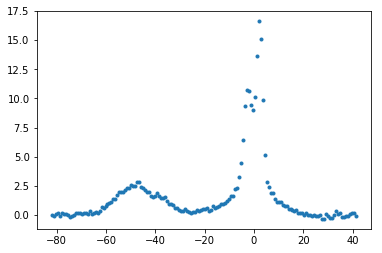

In [3]:
fitsname = "GHIGLS_NCPL_Tb_INPAINTED_UNCUT.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header

hdr['CRPIX1'] -= 197
hdr['CRPIX2'] -= 246
hdr['CRPIX3'] -= 215

cube = hdu[0].data[0][215:369,246:374, 197:325]
#cube = cube[:, :32, :32]

rms = hdu[2].data[246:374,197:325]
#rms = rms[:32, :32]

CRVAL = hdr['CRVAL3']
CDELT = hdr['CDELT3']
CRPIX = hdr['CRPIX3']

ind_array = np.arange(cube.shape[0])

v = (CRVAL + CDELT*((ind_array) - CRPIX))/1000

plt.plot(v, cube[:,15,15], linestyle = "none", marker = '.')

print(np.shape(cube))

Opening data file


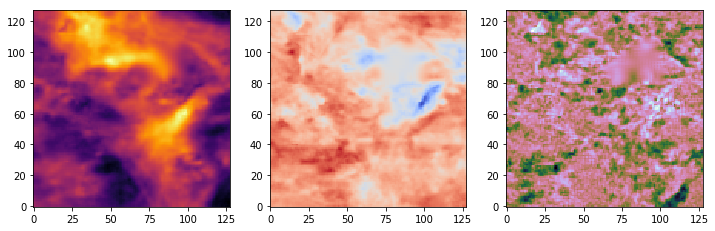

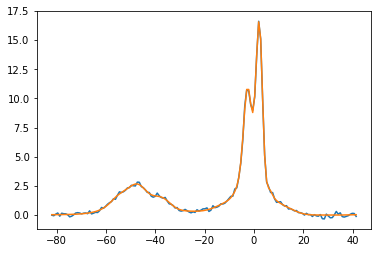

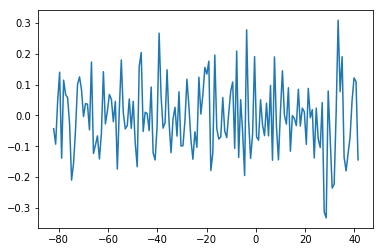

140.01937063329996
1.4895677726946803


In [4]:
n_gauss = 20
core = ROHSA(cube, hdr=hdr)
gaussian = core.read_gaussian("GHIGLS_UMA_Tb_INPAINTED_gauss_run_fullcube_0.dat")

model = core.return_result_cube(gaussian=gaussian)
params = core.physical_gaussian(gaussian)


amplitude = gaussian[0::3]
position = gaussian[1::3]
dispersion = gaussian[2::3]

integral = amplitude * dispersion

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(amplitude[0], origin="lower", cmap="inferno")
plt.subplot(1,3,2)
plt.imshow(position[0], origin="lower", cmap="coolwarm")
plt.subplot(1,3,3)
plt.imshow(dispersion[0], origin="lower", cmap="cubehelix")
plt.show()

plt.plot(core.v, cube[:,15,15])
plt.plot(core.v, model[:,15,15])

plt.show()

residual = cube[:,15,15] - model[:,15,15]
plt.plot(core.v, residual)
plt.show()


noise = rms[15,15]*(1+(cube[:,15,15]/20))
chi2 = np.sum(residual**2/noise**2)
print(chi2)

dim = len(core.v)
rd_chi2 = chi2 / (dim-(3*n_gauss))
print(rd_chi2)

[1.29048448 4.24718679 3.86369094 5.15417708 1.57686677 6.27597366
 1.60450471 1.33084747 1.28616312 7.67350033 7.91339262 1.83943283
 1.86512485 2.3155134  5.4533597  1.44387225 5.6077355  3.85073095
 2.95913717 4.06949936]


/opt/python/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


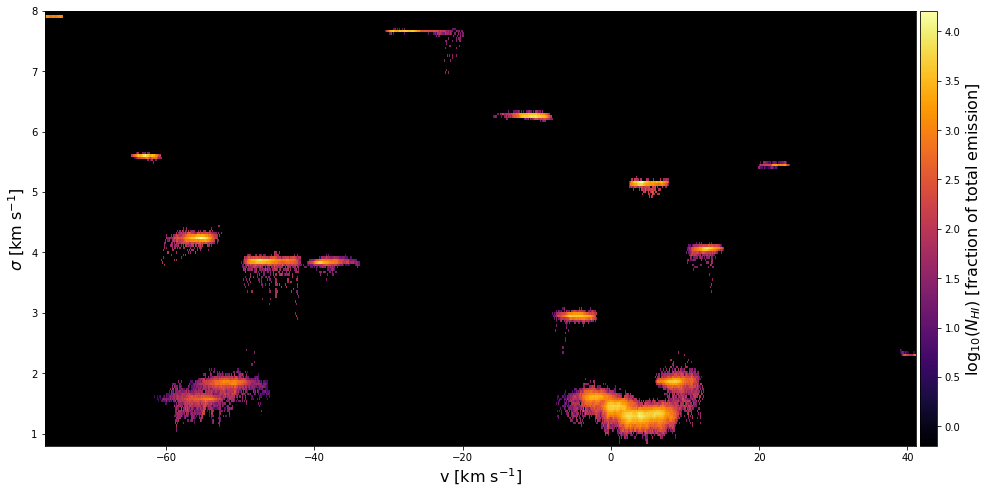

In [5]:
#HEATMAP
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

mean_disp = np.mean(params[2::3], axis = (1,2))
print(mean_disp)
x_bins = np.linspace(np.min(params[1::3].ravel()),
np.max(params[1::3].ravel()), 800)
y_bins = np.linspace(0.8,33., 800)
H, xedges, yedges = np.histogram2d(params[1::3].ravel(),
params[2::3].ravel(),
weights=np.sqrt(2.*np.pi)*params[0::3].ravel()*(params[2::3].ravel()),
                                    bins=[x_bins, y_bins])
H = np.ma.masked_invalid(np.atleast_2d(H))
fig = plt.figure(figsize=(16.,8.))
ax = fig.add_subplot(111)
ax.set_ylim([0.8, 8.])
ax.set_xlim([np.min(params[1::3].ravel()),np.max(params[1::3].ravel())])
ax.set_xlabel(r'v [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap="inferno")
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(r'log$_{10}$($N_{HI}$) [fraction of total emission]',
fontsize = 16)
plt.savefig("NCPL Plots/" + 'heatmap.png', format='png', bbox_inches='tight',
pad_inches=0.02)

In [6]:
C = 1.823e18

field = params[0::3] * params[2::3] * np.sqrt(2.*np.pi) * C / 1.e18
#field is a cube of column density maps
ampfield = params[0::3]
vfield = params[1::3]
sigfield = params[2::3]

ampfield_pix = gaussian[0::3]
vfield_pix = gaussian[1::3]
sigfield_pix = gaussian[2::3]

iddx = np.argsort(np.mean(vfield, axis=(1,2)))

field = [field[idd] for idd in iddx]
vfield = [vfield[idd] for idd in iddx]
ampfield = [ampfield[idd] for idd in iddx]
sigfield = [sigfield[idd] for idd in iddx]

mean_sig = np.array([np.around(np.mean(sigfields), decimals=1) for sigfields in sigfield])
mean_v = np.array([np.around(np.mean(vfields), decimals=1) for vfields in vfield])

vfield_pix = [vfield_pix[idd] for idd in iddx]
ampfield_pix = [ampfield_pix[idd] for idd in iddx]
sigfield_pix = [sigfield_pix[idd] for idd in iddx]

#Reconstruct cube phase
#LVC
idx_CNM = np.where((mean_sig < 1.8) & (mean_v > -10))[0]
idx_LNM = np.where((mean_sig > 1.8) & (mean_sig < 4.5) & (mean_v > -10))[0]
idx_WNM = np.where((mean_sig > 4.5) & (mean_v > -10))[0]

model_CNM =core.return_result_cube(ampfield=np.array(ampfield_pix)[idx_CNM],
pixfield=np.array(vfield_pix)[idx_CNM],
sigfield=np.array(sigfield_pix)[idx_CNM])

model_LNM = core.return_result_cube(ampfield=np.array(ampfield_pix)[idx_LNM],
pixfield=np.array(vfield_pix)[idx_LNM],
sigfield=np.array(sigfield_pix)[idx_LNM])

model_WNM = core.return_result_cube(ampfield=np.array(ampfield_pix)[idx_WNM],
pixfield=np.array(vfield_pix)[idx_WNM],
sigfield=np.array(sigfield_pix)[idx_WNM])


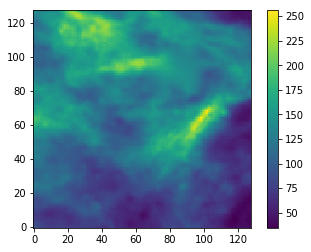

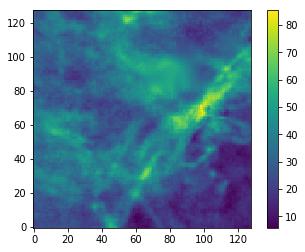

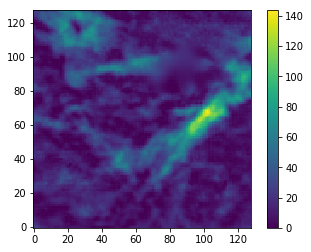

In [7]:
plt.imshow(np.sum(model_CNM, 0), origin = 'lower')
plt.colorbar()
plt.show()
plt.imshow(np.sum(model_LNM, 0), origin = 'lower')
plt.colorbar()
plt.show()
plt.imshow(np.sum(model_WNM, 0), origin = 'lower')
plt.colorbar()

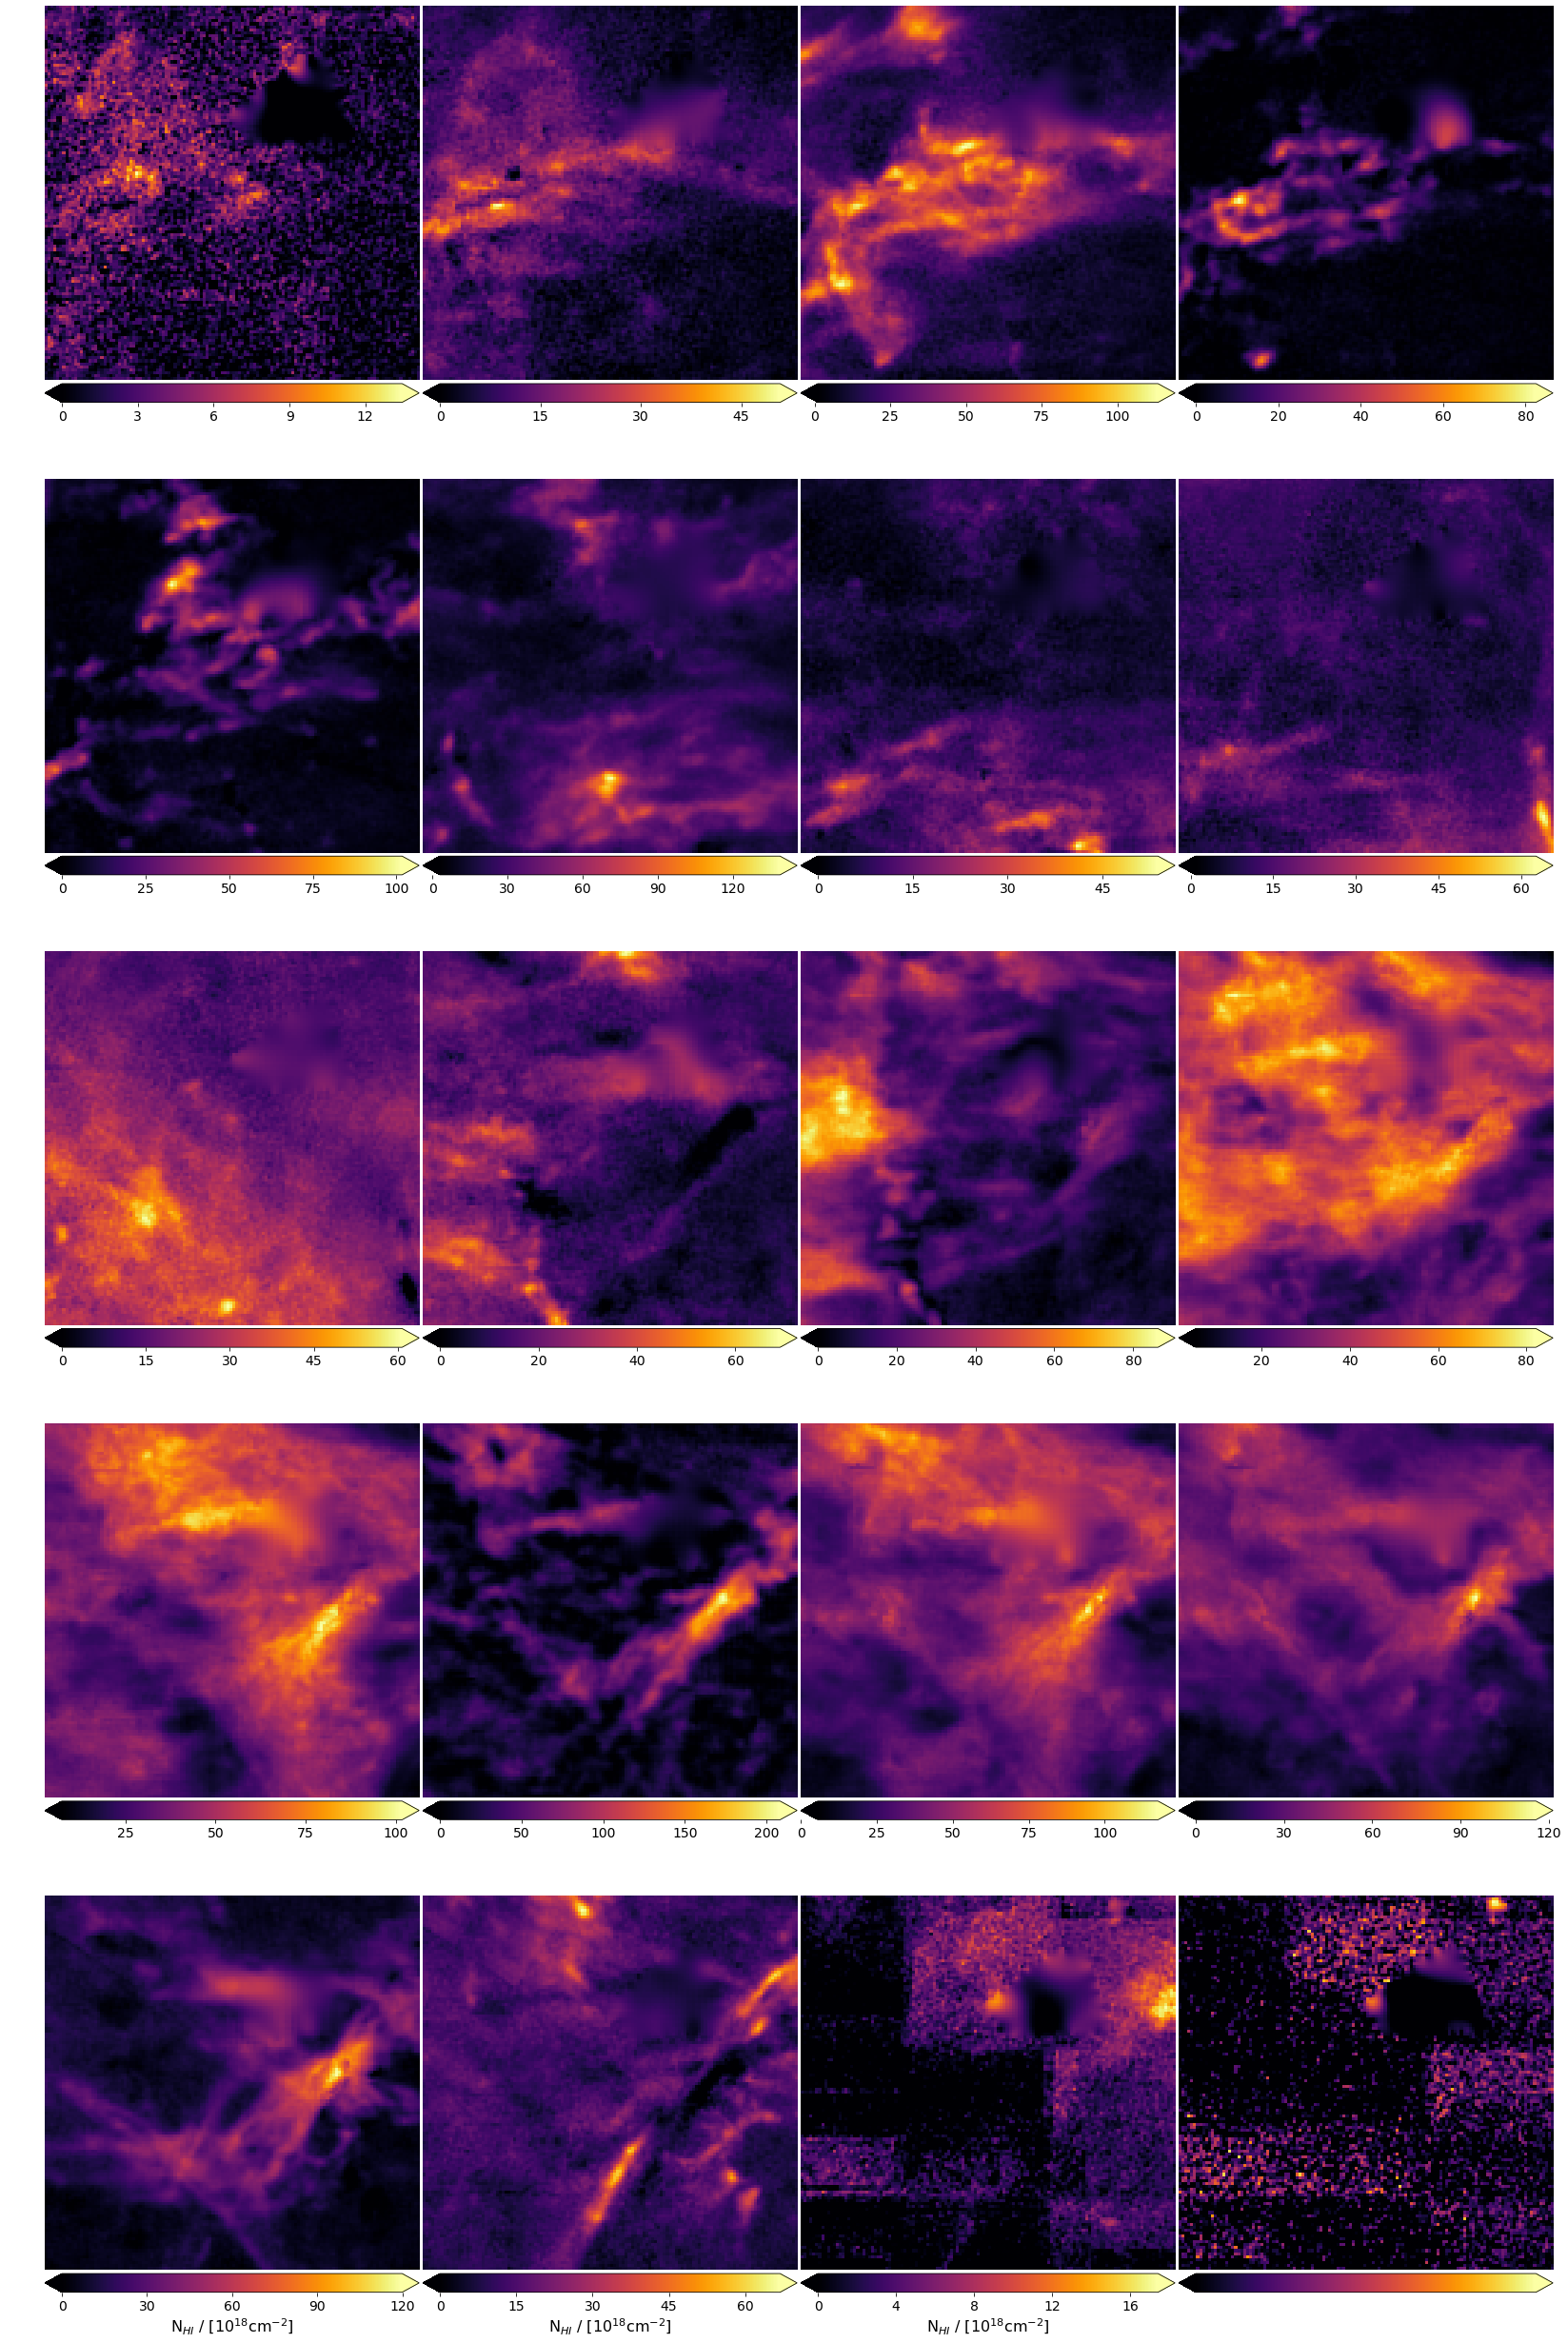

In [8]:
#Plot mosaic field
from matplotlib import ticker
lh = 5; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True,figsize=(22.,35.5))
                        
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12,wspace=0.01)
k = 0
for i in np.arange(lh):
     for j in np.arange(lw):
         im = axs[i][j].imshow(field[k], origin = 'lower', cmap = 'inferno')
         if j == 0: axs[i][j].set_ylabel(r'y')
         axs[i][j].set_xlabel(r'x')
         axs[i][j].axes.xaxis.set_ticklabels([])
         axs[i][j].axis('off')
         divider = make_axes_locatable(axs[i][j])
         cax = divider.append_axes('bottom', size='5%', pad=0.05)
         cbar = fig.colorbar(im, cax=cax, orientation='horizontal',
extend="both")
         tick_locator = ticker.MaxNLocator(nbins=5)
         cbar.locator = tick_locator
         cbar.update_ticks()
         cbar.ax.tick_params(labelsize=14.)
         if i == lh-1 : cbar.set_label(r"N$_{HI}$ / [10$^{18}$cm$^{-2}$]", fontsize=16.)
         k += 1
plt.axis('off')
plt.savefig('NCPL Plots/mosaic_field.pdf', format='pdf')

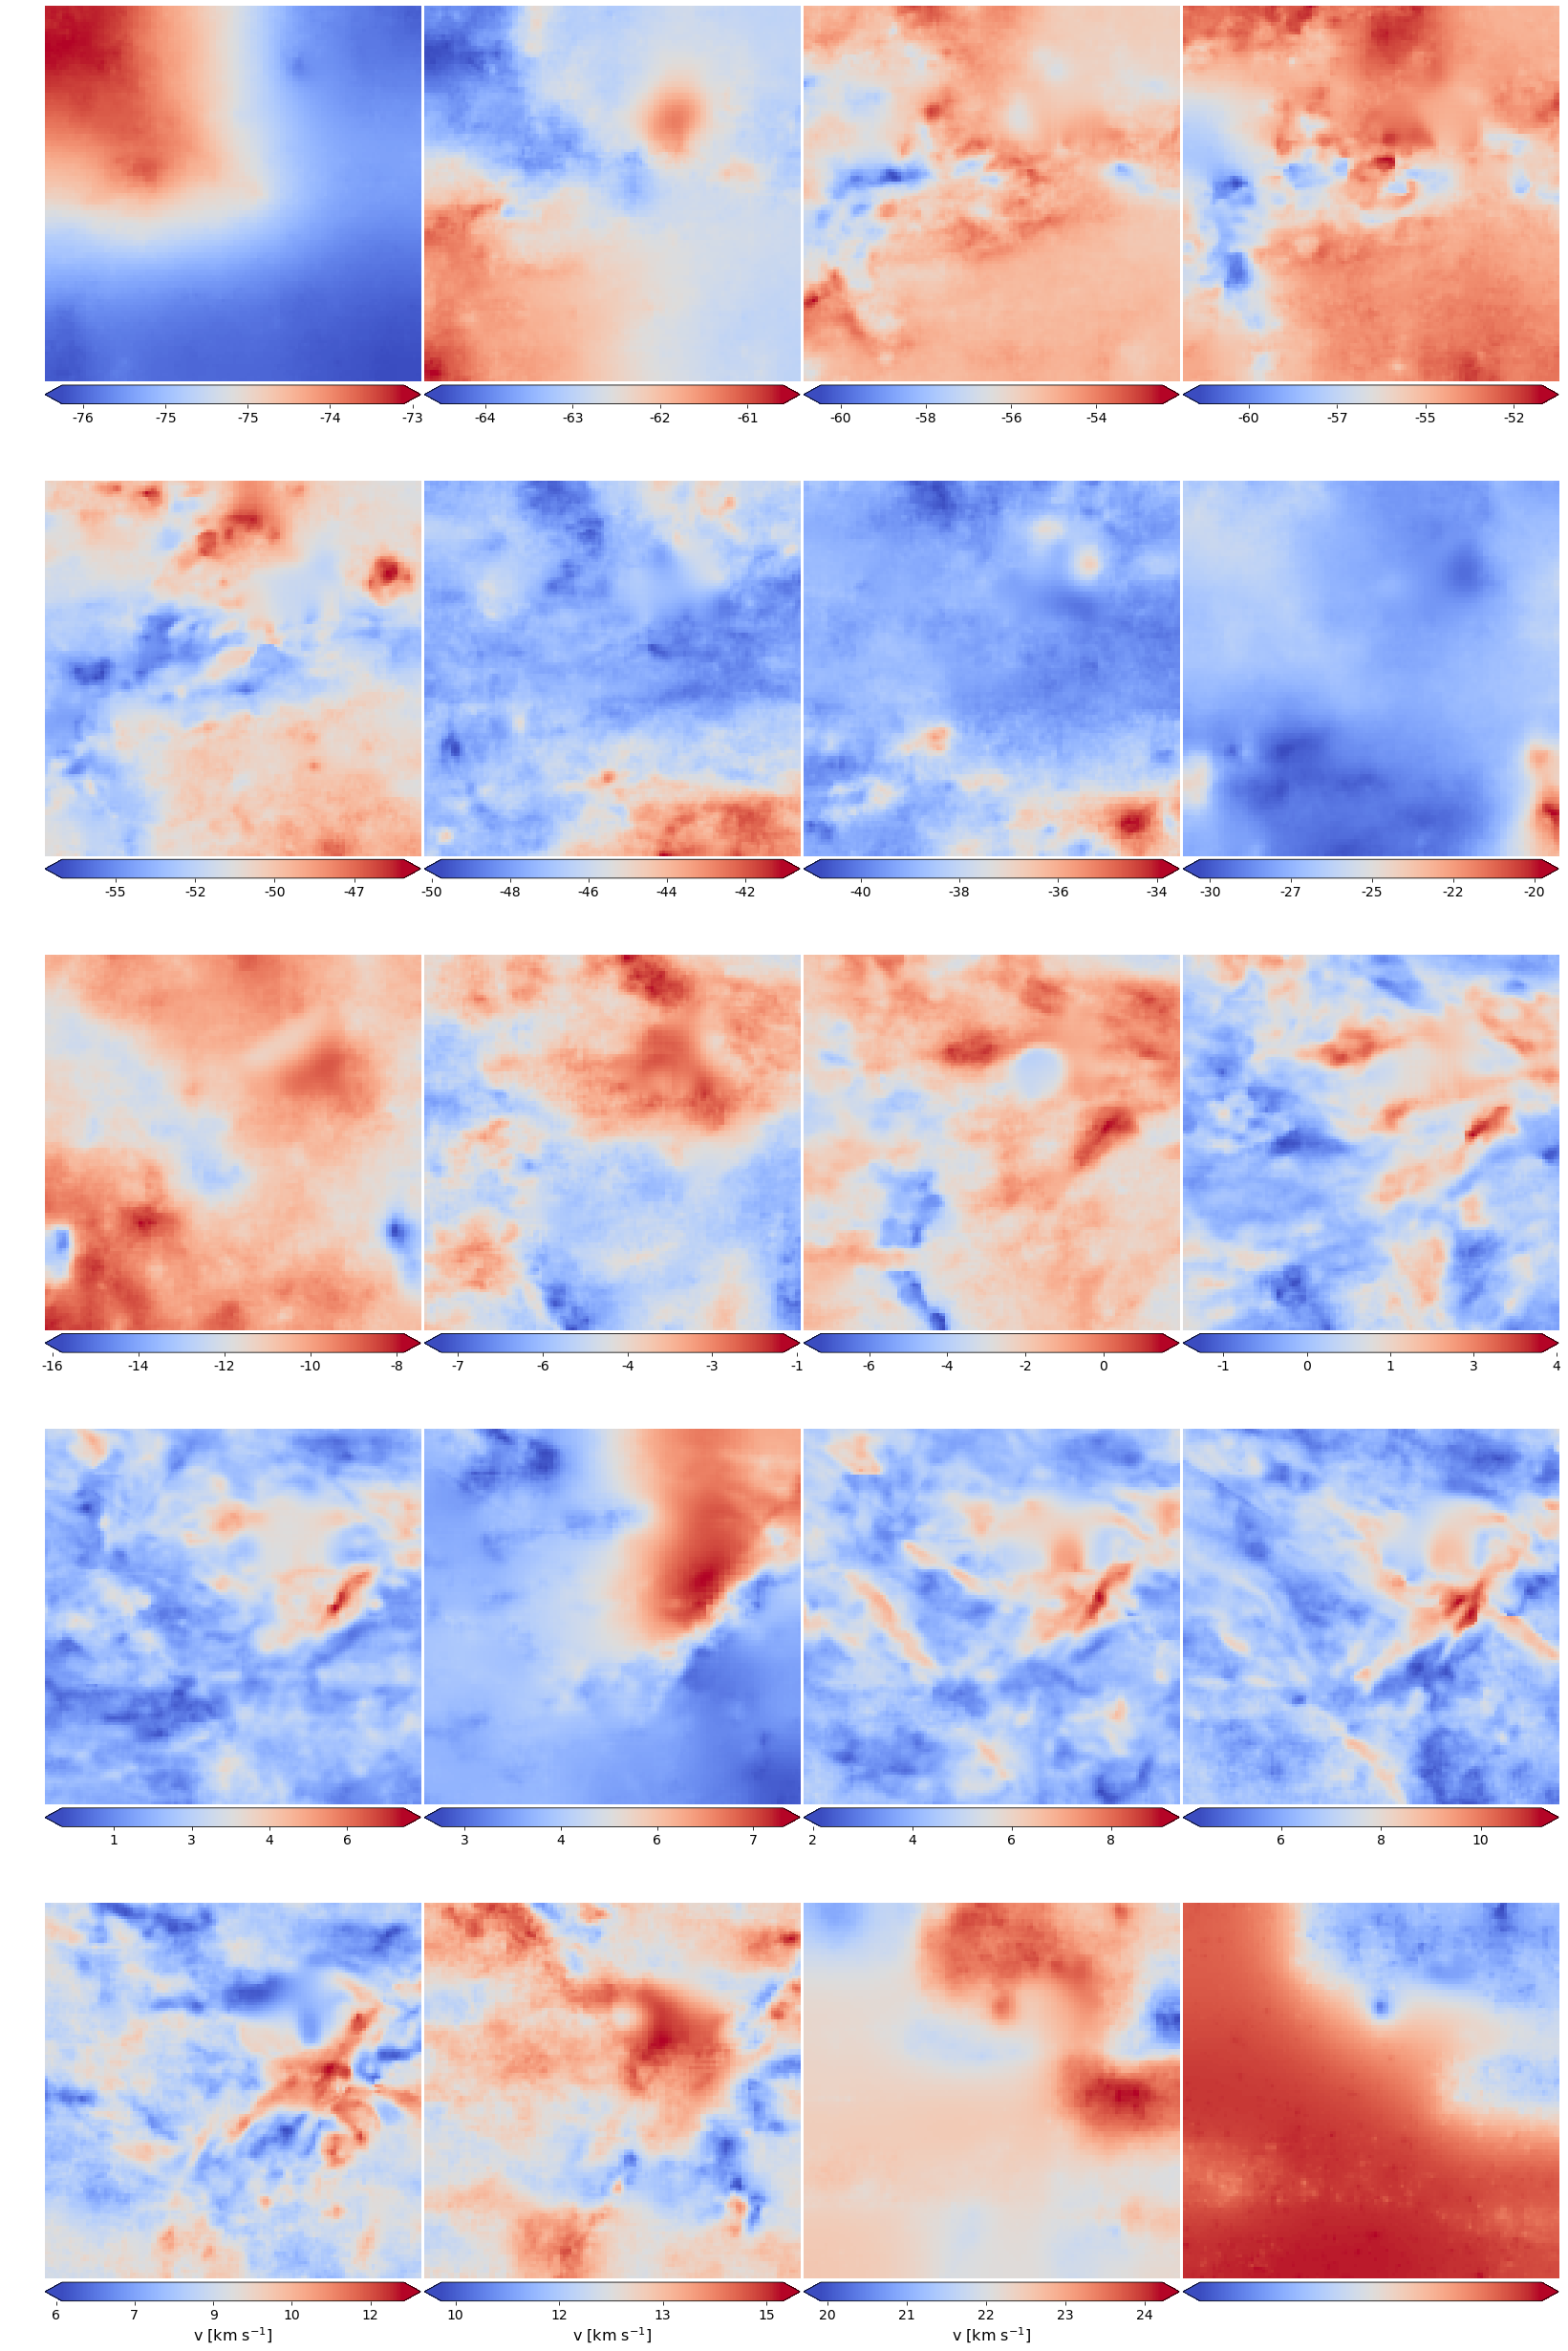

In [9]:
#Plot mosaic field mean
lh = 5; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True,figsize=(((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12,
wspace=0.01)
k = 0
for i in np.arange(lh):
     for j in np.arange(lw):
         elev_min=np.nanmin(vfield[k])
         elev_max=np.nanmax(vfield[k])
         mid_val=0
         im1 = axs[i][j].imshow(vfield[k],origin = 'lower', cmap = 'coolwarm')
         if j == 0: axs[i][j].set_ylabel(r'y')
         axs[i][j].set_xlabel(r'x')
         axs[i][j].axes.xaxis.set_ticklabels([])
         axs[i][j].axis('off')
         divider = make_axes_locatable(axs[i][j])
         cax = divider.append_axes('bottom', size='5%', pad=0.05)
         cbar = fig.colorbar(im1, cax=cax, orientation='horizontal',
format='%d', extend="both")
         tick_locator = ticker.MaxNLocator(nbins=5)
         cbar.locator = tick_locator
         cbar.update_ticks()
         cbar.ax.tick_params(labelsize=14.)
         if i == lh-1 : cbar.set_label(r"v [km s$^{-1}$]", fontsize=16.)
         k += 1
            
plt.axis('off')
plt.savefig('NCPL Plots/mosaic_vfield.pdf', format='pdf')

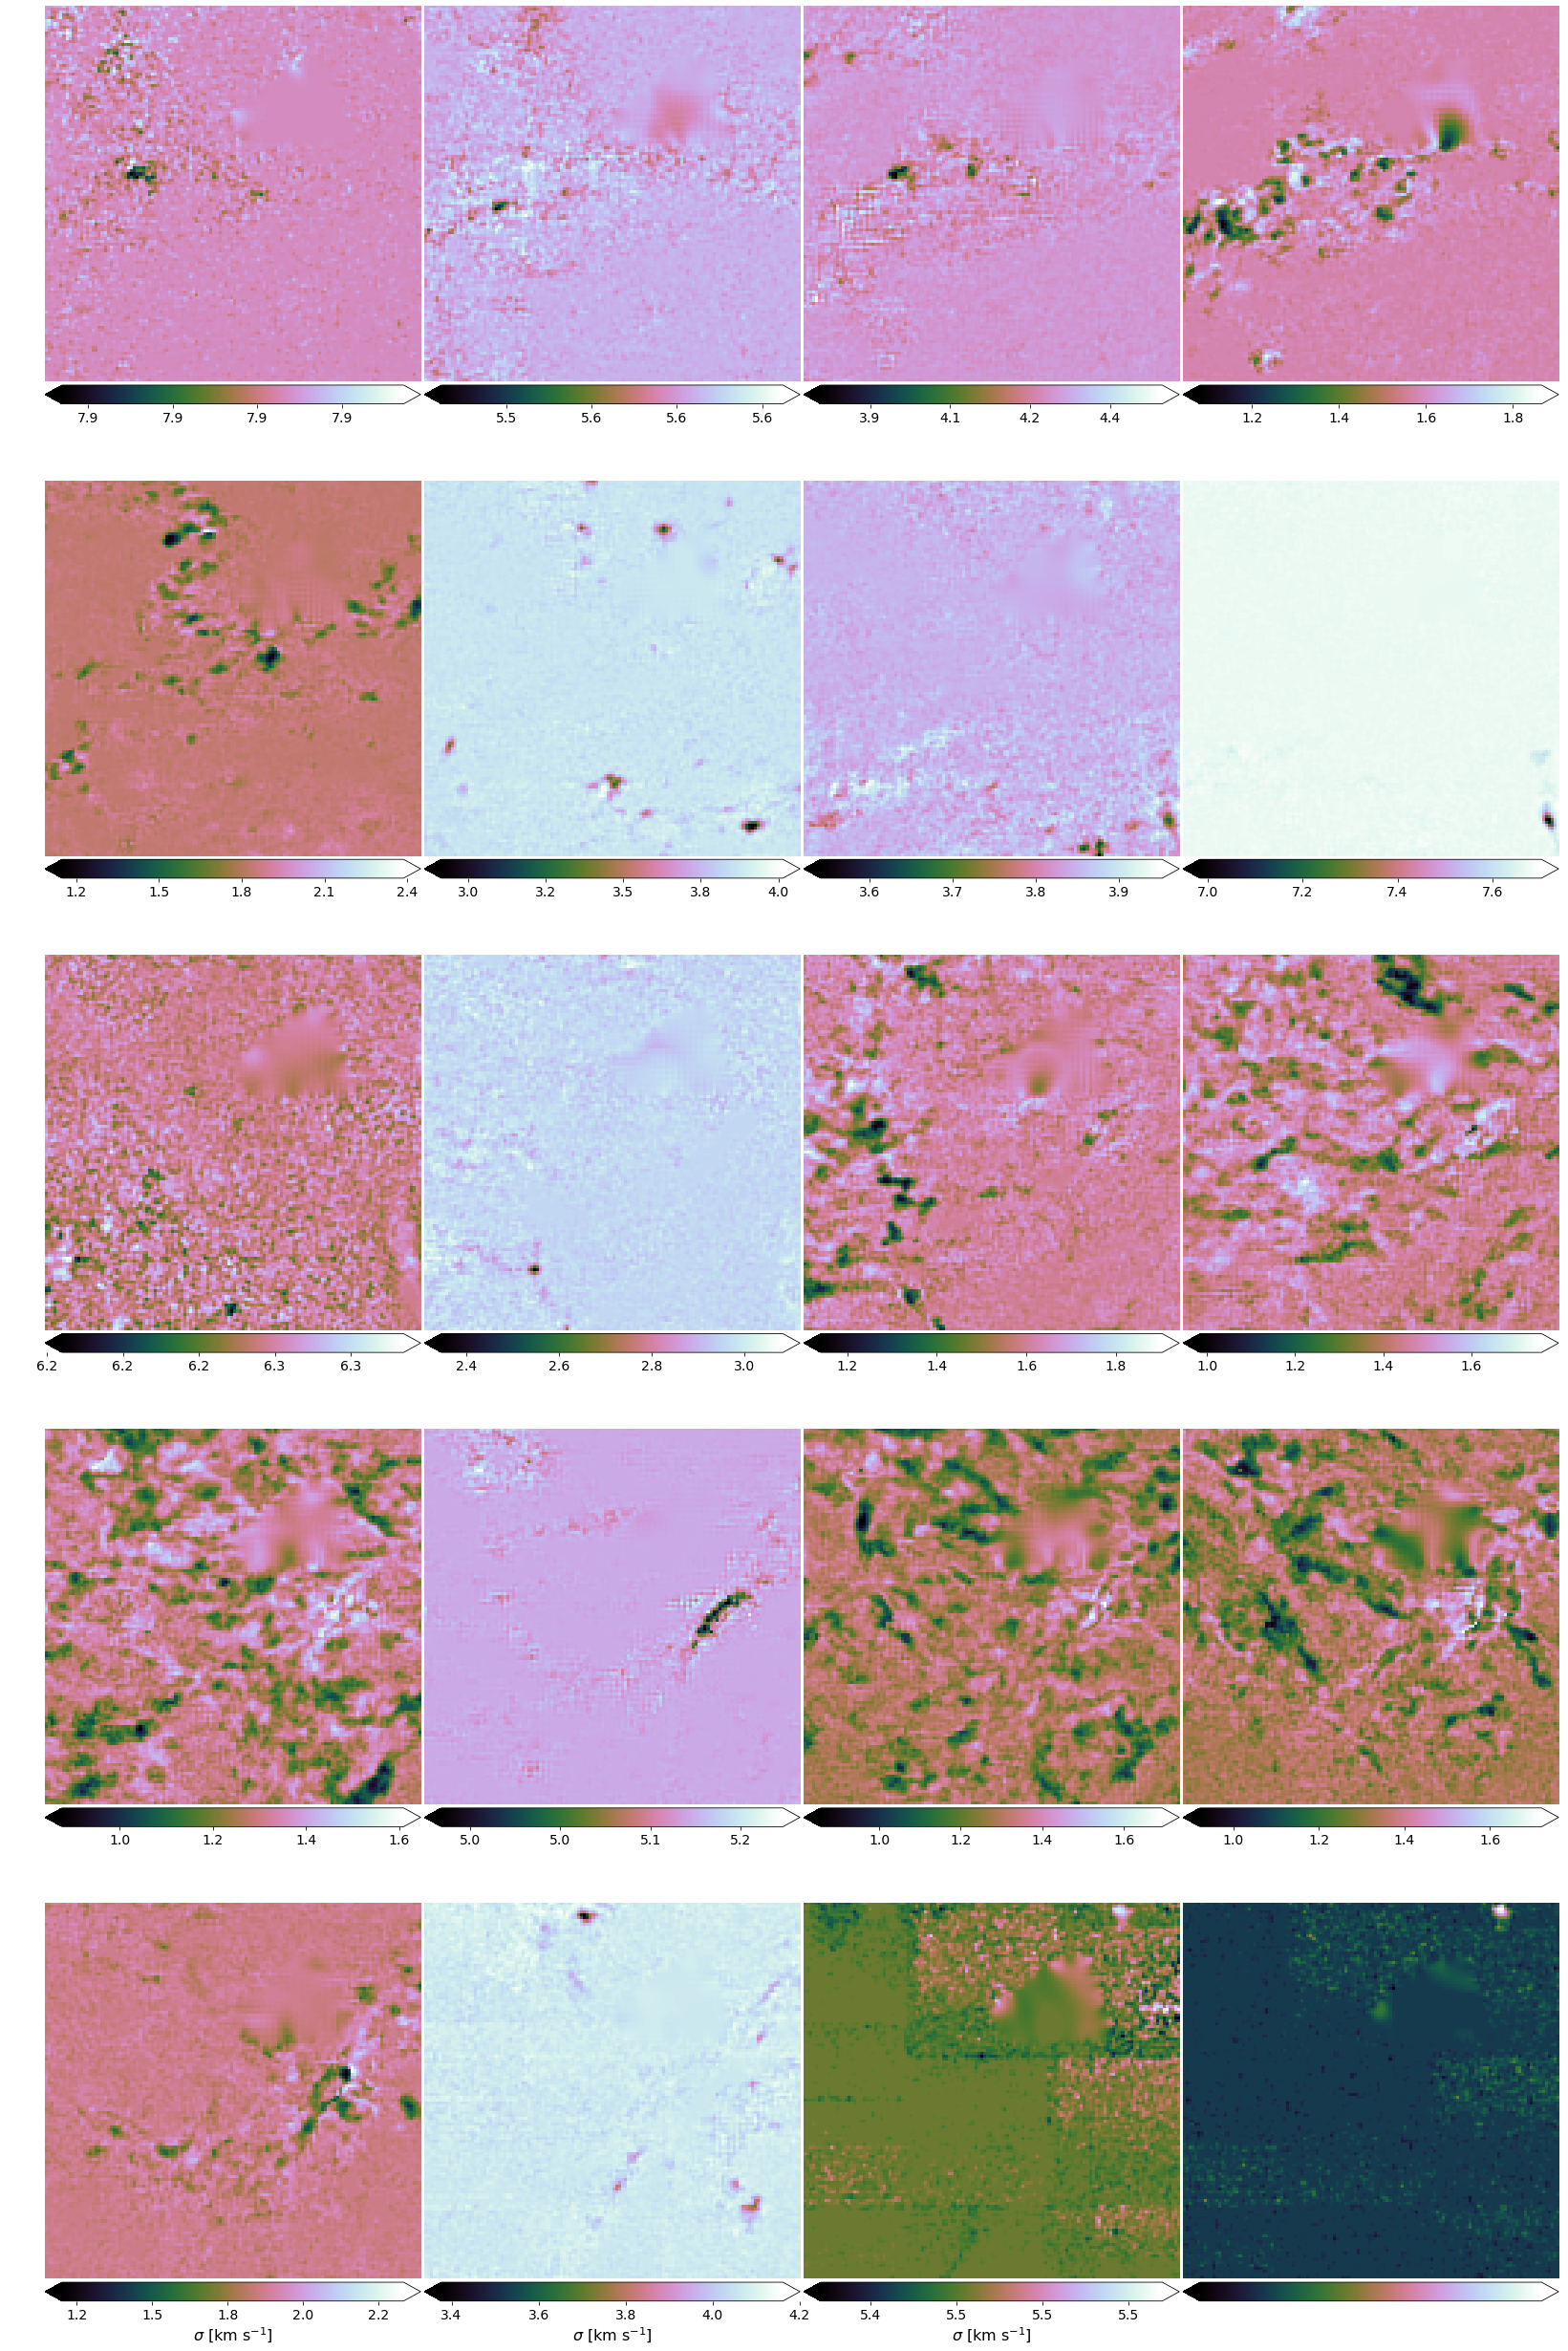

In [10]:
#Plot mosaic field sigma
lh = 5; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True,figsize=(((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12,
wspace=0.01)
k = 0
for i in np.arange(lh):
     for j in np.arange(lw):
         im1 = axs[i][j].imshow(sigfield[k], origin = 'lower', cmap = 'cubehelix')
         if j == 0: axs[i][j].set_ylabel(r'y')
         axs[i][j].set_xlabel(r'x')
         axs[i][j].axes.xaxis.set_ticklabels([])
         axs[i][j].axis('off')
         divider = make_axes_locatable(axs[i][j])
         cax = divider.append_axes('bottom', size='5%', pad=0.05)
         cbar = fig.colorbar(im1, cax=cax, orientation='horizontal',
format='%.1f', extend="both")
         tick_locator = ticker.MaxNLocator(nbins=5)
         cbar.locator = tick_locator
         cbar.update_ticks()
         cbar.ax.tick_params(labelsize=14.)
         if i == lh-1 : cbar.set_label(r"$\sigma$ [km s$^{-1}$]",
fontsize=16.)
         k += 1
plt.axis('off')
plt.savefig('NCPL Plots/mosaic_sigfield.pdf', format='pdf')


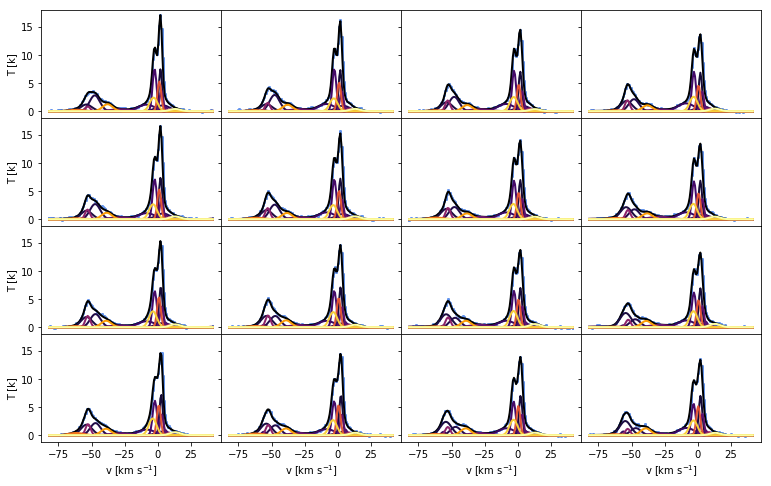

In [11]:
#Plot mosaic spectra
pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
     return (pval - pmin) / float(pmax - pmin)

ny = 4; nx = 4
center_y = 16; center_x = 16
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
     for j in np.arange(nx):
         axs[i][j].step(core.v, cube[:,center_y+i,center_x+j],
color='cornflowerblue', linewidth=2.)
         axs[i][j].plot(core.v,
model[:,center_y+i,center_x+j], linestyle="-",
linewidth=2., color="k")
         for k in range(int(params.shape[0]/3)):
             axs[i][j].plot(core.v, core.gauss(np.arange(len(core.v)),
            gaussian[0::3][k][center_y+i,center_x+j],
            gaussian[1::3][k][center_y+i,center_x+j],
            gaussian[2::3][k][center_y+i,center_x+j]),
                            linewidth=2., color=plt.cm.inferno(pvalues[k]))
         if j == 0: axs[i][j].set_ylabel(r'T [k]')
         axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
plt.savefig("NCPL Plots/" + 'mosaic_spectra_all.png', format='png',
bbox_inches='tight', pad_inches=0.02)

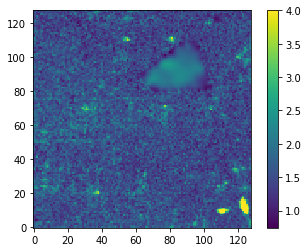

In [12]:
#now i will make a map of the chi2 values over the original for loops

noise1 = rms*(1+(cube/20))
residual = cube - model

chi2_cont = (residual/noise1)**2
chi2 = np.sum(residual**2/noise1**2, axis = 0)
dim = len(core.v)
rchi2 = chi2 / (dim-(3*n_gauss))


#plt.imshow(np.sum(chi2_cont, 0), origin = 'lower')
#plt.colorbar()
#plt.show()

plt.imshow(rchi2, origin = "lower", vmax = 4)
plt.colorbar()
plt.savefig('NCPL Plots/reducedchisquare.png')


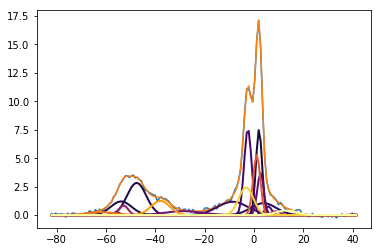

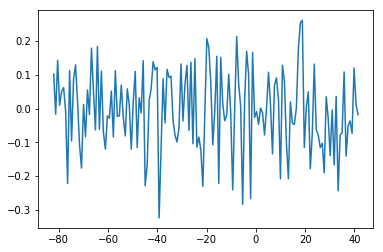

In [13]:

plt.plot(core.v, cube[:,center_y,center_x])
plt.plot(core.v, model[:,center_y,center_x])
for k in range(int(params.shape[0]/3)):
             plt.plot(core.v, core.gauss(np.arange(len(core.v)),
            gaussian[0::3][k][center_y,center_x],
            gaussian[1::3][k][center_y,center_x],
            gaussian[2::3][k][center_y,center_x]),
                            linewidth=2., color=plt.cm.inferno(pvalues[k]))

plt.savefig('NCPL Plots/individualspectrum.png')
plt.show()


residual = cube[:,center_y,center_x] - model[:,center_y,center_x]
plt.plot(core.v, residual)
plt.savefig('NCPL Plots/residualofindividualspectrum.png')

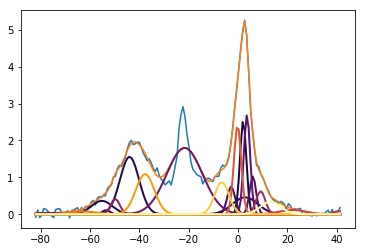

In [14]:
badcenter_x = 125
badcenter_y = 10

plt.plot(core.v, cube[:,badcenter_y,badcenter_x])
plt.plot(core.v, model[:,badcenter_y,badcenter_x])

for k in range(int(params.shape[0]/3)):
             plt.plot(core.v, core.gauss(np.arange(len(core.v)),
            gaussian[0::3][k][badcenter_y,badcenter_x],
            gaussian[1::3][k][badcenter_y,badcenter_x],
            gaussian[2::3][k][badcenter_y,badcenter_x]),
                      linewidth=2., color=plt.cm.inferno(pvalues[k]))
  